In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms



LOADING THE DATASET

In [ ]:
EPOCHS = 30
data_dir = "C:\\Users\\Ashiq\\Documents\\Documents\\pytorch project\\chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [ ]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import os

data_dir = r"C:\Users\Ashiq\Documents\Documents\pytorch project\chest_xray"
categories = ['train', 'val', 'test']

for category in categories:
    category_path = os.path.join(data_dir, category)
    if not os.path.exists(category_path):
        print(f"The directory {category_path} does not exist.")
    else:
        print(f"Contents of {category_path}:")
        class_dirs = [d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d))]
        if not class_dirs:
            print("  Warning: No class directories found.")
        for class_dir in class_dirs:
            class_dir_path = os.path.join(category_path, class_dir)
            files = os.listdir(class_dir_path)
            print(f"  {class_dir}: {len(files)} files found.")
            for f in files[:5]:  # Print the first 5 file names
                print(f"    - {f}")


Contents of C:\Users\Ashiq\Documents\Documents\pytorch project\chest_xray\train:
  NORMAL: 1349 files found.
    - IM-0115-0001.jpeg
    - IM-0117-0001.jpeg
    - IM-0119-0001.jpeg
    - IM-0122-0001.jpeg
    - IM-0125-0001.jpeg
  PNEUMONIA: 3884 files found.
    - .DS_Store
    - person1000_bacteria_2931.jpeg
    - person1000_virus_1681.jpeg
    - person1001_bacteria_2932.jpeg
    - person1002_bacteria_2933.jpeg
Contents of C:\Users\Ashiq\Documents\Documents\pytorch project\chest_xray\val:
  NORMAL: 350 files found.
    - IM-0001-0001.jpeg
    - IM-0003-0001.jpeg
    - IM-0005-0001.jpeg
    - IM-0006-0001.jpeg
    - IM-0007-0001.jpeg
  PNEUMONIA: 289 files found.
    - person10_bacteria_43.jpeg
    - person117_bacteria_553.jpeg
    - person117_bacteria_556.jpeg
    - person117_bacteria_557.jpeg
    - person118_bacteria_559.jpeg
Contents of C:\Users\Ashiq\Documents\Documents\pytorch project\chest_xray\test:
  NORMAL: 234 files found.
    - IM-0001-0001.jpeg
    - IM-0003-0001.jpeg
    

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True),
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True),
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [ ]:
len(dataloaders[TRAIN])

1308

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

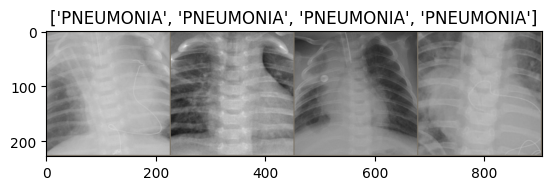

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == VAL:
                val_losses.append(epoch_loss)
            else:
                train_losses.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Plot loss curve
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return model


MODEL LOADING VGG16

In [ ]:
import torchvision.models as models

# This will automatically download the pretrained weights for VGG16
# and load them into the model.
model_pre = models.vgg16(pretrained=True)


c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

MODEL TRAINING

Epoch: 1/30


c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.1703 Acc: 0.9287
val Loss: 0.2496 Acc: 0.9014
Epoch: 2/30
train Loss: 0.0760 Acc: 0.9719
val Loss: 0.1769 Acc: 0.9390
Epoch: 3/30
train Loss: 0.0623 Acc: 0.9759
val Loss: 0.1023 Acc: 0.9640
Epoch: 4/30
train Loss: 0.0575 Acc: 0.9776
val Loss: 0.1174 Acc: 0.9640
Epoch: 5/30
train Loss: 0.0613 Acc: 0.9761
val Loss: 0.2160 Acc: 0.9202
Epoch: 6/30
train Loss: 0.0599 Acc: 0.9773
val Loss: 0.0972 Acc: 0.9656
Epoch: 7/30
train Loss: 0.0667 Acc: 0.9750
val Loss: 0.1410 Acc: 0.9452
Epoch: 8/30
train Loss: 0.0668 Acc: 0.9755
val Loss: 0.2701 Acc: 0.9092
Epoch: 9/30
train Loss: 0.0685 Acc: 0.9734
val Loss: 0.2040 Acc: 0.9296
Epoch: 10/30
train Loss: 0.0409 Acc: 0.9864
val Loss: 0.1524 Acc: 0.9499
Epoch: 11/30
train Loss: 0.0347 Acc: 0.9885
val Loss: 0.2109 Acc: 0.9374
Epoch: 12/30
train Loss: 0.0314 Acc: 0.9904
val Loss: 0.2181 Acc: 0.9311
Epoch: 13/30
train Loss: 0.0300 Acc: 0.9899
val Loss: 0.2487 Acc: 0.9280
Epoch: 14/30
train Loss: 0.0282 Acc: 0.9918
val Loss: 0.1602 Acc: 0.9484

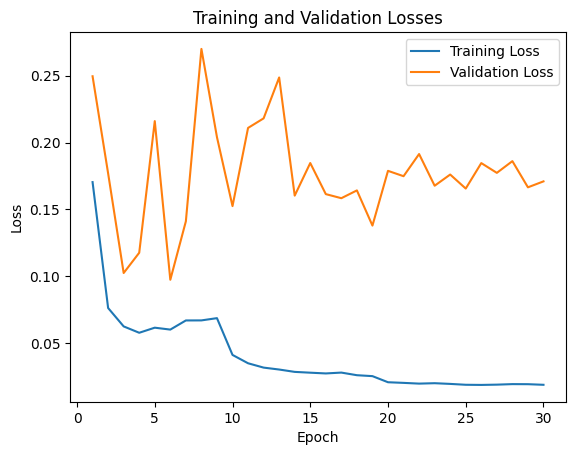

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/30


c:\Users\Ashiq\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 3.5879 Acc: 0.9207
val Loss: 1.1551 Acc: 0.9437
Epoch: 2/30
train Loss: 1.0837 Acc: 0.9537
val Loss: 2.6332 Acc: 0.9030
Epoch: 3/30
train Loss: 0.5051 Acc: 0.9681
val Loss: 2.1492 Acc: 0.9609
Epoch: 4/30
train Loss: 0.4296 Acc: 0.9702
val Loss: 1.5383 Acc: 0.9437
Epoch: 5/30
train Loss: 0.2026 Acc: 0.9797
val Loss: 1.8376 Acc: 0.9562
Epoch: 6/30
train Loss: 0.1249 Acc: 0.9843
val Loss: 0.9859 Acc: 0.9593
Epoch: 7/30
train Loss: 0.0884 Acc: 0.9862
val Loss: 0.9280 Acc: 0.9562
Epoch: 8/30
train Loss: 0.0325 Acc: 0.9916
val Loss: 1.1881 Acc: 0.9484
Epoch: 9/30
train Loss: 0.0240 Acc: 0.9931
val Loss: 0.9735 Acc: 0.9546
Epoch: 10/30
train Loss: 0.0183 Acc: 0.9939
val Loss: 0.9735 Acc: 0.9546
Epoch: 11/30
train Loss: 0.0137 Acc: 0.9958
val Loss: 0.9369 Acc: 0.9562
Epoch: 12/30
train Loss: 0.0194 Acc: 0.9956
val Loss: 0.9166 Acc: 0.9624
Epoch: 13/30
train Loss: 0.0534 Acc: 0.9901
val Loss: 1.1542 Acc: 0.9499
Epoch: 14/30
train Loss: 0.2280 Acc: 0.9813
val Loss: 1.4117 Acc: 0.9562

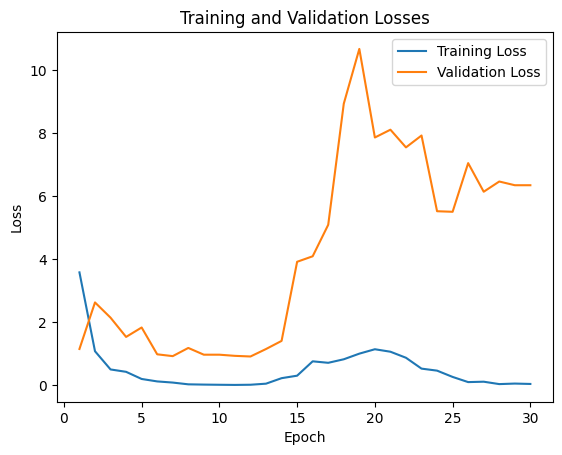

NameError: name 'test_model' is not defined

In [ ]:
import pandas as pd
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
# Assuming train_model and test_model are defined elsewhere, as well as class_names, device, and EPOCHS.

# Initialize an empty DataFrame for logging
log_df = pd.DataFrame(columns=["Experiment No.", "Learning Rate", "Batch Size", "Accuracy"])

# Function to log an experiment
def log_experiment(log_df, experiment_details):
    return log_df.append(experiment_details, ignore_index=True)


def run_experiment(experiment_no, learning_rate, batch_size):
    # Define model, criterion, optimizer, scheduler, etc.
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False

    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(num_features, len(class_names))])
    model.classifier = nn.Sequential(*features)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Using Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    exp_lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

    # Train model
    model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)



    # Log experiment details
    experiment_details = {
        "Experiment No.": experiment_no,
        "Learning Rate": learning_rate,
        "Batch Size": batch_size,
        "Accuracy": acc
    }

    global log_df
    log_df = log_experiment(log_df, experiment_details)

# Hyperparameters
learning_rates = [0.001, 0.002, 0.004]
batch_sizes = [64, 128, 256]

# Run experiments
experiment_no = 1
for lr in learning_rates:
    for bs in batch_sizes:
        run_experiment(experiment_no, lr, bs)
        experiment_no += 1




IN THE ABOVE CODE I HAVE GIVEN THE test_model CODE WHICH IS NOT REQUIRED , THATS WHY IT THROWED AN ERROR , IT IS SHOWING RESULTS AND THE ACCURACY FOR THE DIFFERENT HYPERPARAMTERS . AND IT IS TAKING TOO MUCH TIME LIKE 6 HOURS TO RUN 30 EPOCHS

TESTING

In [ ]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [ ]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [ ]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 536.0, Total Test Images: 624.0
Test Accuracy:  0.8589743589743589


CONFUSION MATRIX

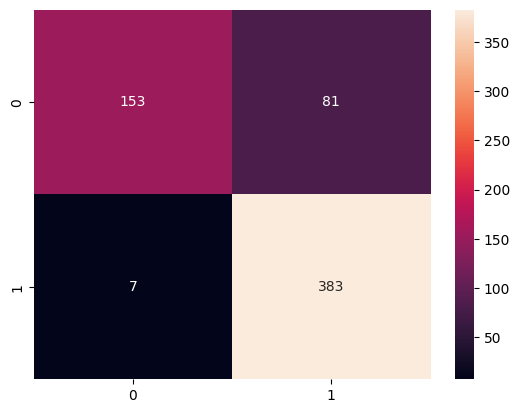

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")